In [1]:
CITY = 2304400
CITY_NAME = 'Fortaleza'
STATE = 'CE'
FILENAME_DATA = f'../../data/dengue_{CITY}_cluster.csv'

In [2]:
import sys
import pickle
sys.path.append('../..')
import numpy as np
import tensorflow as tf
import pandas as pd
from datetime import datetime
from pgbm_model import pgbm_pred
import matplotlib.pyplot as plt
from preprocessing import get_nn_data
from lstm import build_model, make_pred
from plots_lstm import plot_loss, plot_comp 
from sklearn.metrics import mean_squared_error as mse 

In [3]:
df_dengue = pd.read_csv(FILENAME_DATA, index_col = 'Unnamed: 0' )
df_dengue.index = pd.to_datetime(df_dengue.index)
df_dengue

,casos_2304400,casos_est_2304400,casos_est_min_2304400,casos_est_max_2304400,p_rt1_2304400,p_inc100k_2304400,temp_min_2304400,temp_max_2304400,umid_min_2304400,pressao_min_2304400,...,casos_2306306,casos_est_2306306,casos_est_min_2306306,casos_est_max_2306306,p_rt1_2306306,p_inc100k_2306306,temp_min_2306306,temp_max_2306306,umid_min_2306306,pressao_min_2306306
2010-01-03,56,56.0,56,56,0.000000,2.084410,23.333333,28.333333,66.333333,1009.000000,...,0,0.0,0,0,0.000000,0.00000,23.333333,28.333333,66.333333,1009.000000
2010-01-10,55,55.0,55,55,0.000000,2.047188,24.714286,29.714286,59.571429,1009.428571,...,1,1.0,1,1,0.000000,1.88441,24.714286,29.714286,59.571429,1009.428571
2010-01-17,77,77.0,77,77,0.000000,2.866063,25.142857,30.571429,58.142857,1010.714286,...,0,0.0,0,0,0.000000,0.00000,25.142857,30.571429,58.142857,1010.714286
2010-01-24,56,56.0,56,56,0.000000,2.084410,24.714286,30.857143,54.142857,1009.000000,...,0,0.0,0,0,0.000000,0.00000,24.714286,30.857143,54.142857,1009.000000
2010-01-31,114,114.0,114,114,0.000000,4.243262,24.714286,30.571429,61.428571,1007.857143,...,0,0.0,0,0,0.000000,0.00000,24.714286,30.571429,61.428571,1007.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-27,121,157.0,130,214,0.006093,5.843792,26.142857,29.857143,61.059517,1009.142857,...,0,0.0,0,0,0.000000,0.00000,26.142857,29.857143,61.059517,1009.142857
2022-12-04,92,142.0,106,228,0.009726,5.285467,26.142857,30.285714,58.965531,1006.714286,...,2,2.0,2,2,0.858644,3.76882,26.142857,30.285714,58.965531,1006.714286
2022-12-11,81,153.0,102,297,0.327694,5.694905,26.000000,31.000000,58.365561,1009.285714,...,1,1.0,1,1,0.639028,1.88441,26.000000,31.000000,58.365561,1009.285714
2022-12-18,43,144.0,70,384,0.366084,5.359910,26.166667,30.333333,60.203788,1009.333333,...,0,0.0,0,0,0.000000,0.00000,26.166667,30.333333,60.203788,1009.333333


## Neural network model 

Parameters of the models:

In [4]:
END_DATE = '2022-01-09' # assign the last day used to evaluate the dengue model 

PREDICT_N = 4 # number of new days predicted
LOOK_BACK = 4 # number of last days used to make the prediction 
EPOCHS = 400
HIDDEN = 8
FEAT = 52 # number of features 

Let's train the model with the loss function == msle 

Compilation Time :  0.0035698413848876953
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 52)]           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             3904      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
  

2023-03-11 19:30:16.581159: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


395/395 [==============================] - 3s 4ms/step - loss: 0.0083 - accuracy: 0.2962 - mape: 146.7583 - mse: 0.0137 - val_loss: 0.0053 - val_accuracy: 0.2143 - val_mape: 80.4293 - val_mse: 0.0098
Epoch 2/400
395/395 [==============================] - 1s 3ms/step - loss: 0.0039 - accuracy: 0.2557 - mape: 93.8594 - mse: 0.0068 - val_loss: 0.0052 - val_accuracy: 0.3429 - val_mape: 138.7009 - val_mse: 0.0093
Epoch 3/400
395/395 [==============================] - 1s 3ms/step - loss: 0.0030 - accuracy: 0.2532 - mape: 86.4056 - mse: 0.0054 - val_loss: 0.0041 - val_accuracy: 0.2714 - val_mape: 90.5566 - val_mse: 0.0078
Epoch 4/400
395/395 [==============================] - 1s 3ms/step - loss: 0.0026 - accuracy: 0.2557 - mape: 81.2197 - mse: 0.0048 - val_loss: 0.0045 - val_accuracy: 0.3286 - val_mape: 102.8355 - val_mse: 0.0089
Epoch 5/400
395/395 [==============================] - 2s 4ms/step - loss: 0.0030 - accuracy: 0.2987 - mape: 86.5925 - mse: 0.0054 - val_loss: 0.0036 - val_accuracy:

Epoch 40/400
395/395 [==============================] - 2s 4ms/step - loss: 0.0018 - accuracy: 0.4152 - mape: 78.7380 - mse: 0.0034 - val_loss: 0.0026 - val_accuracy: 0.5286 - val_mape: 88.7316 - val_mse: 0.0052
Epoch 41/400
395/395 [==============================] - 2s 4ms/step - loss: 0.0015 - accuracy: 0.4557 - mape: 75.5310 - mse: 0.0026 - val_loss: 0.0023 - val_accuracy: 0.4143 - val_mape: 70.8400 - val_mse: 0.0045
Epoch 42/400
395/395 [==============================] - 2s 4ms/step - loss: 0.0019 - accuracy: 0.4076 - mape: 76.7455 - mse: 0.0034 - val_loss: 0.0022 - val_accuracy: 0.5143 - val_mape: 127.0640 - val_mse: 0.0043
Epoch 43/400
395/395 [==============================] - 2s 4ms/step - loss: 0.0017 - accuracy: 0.4557 - mape: 69.7539 - mse: 0.0031 - val_loss: 0.0019 - val_accuracy: 0.5286 - val_mape: 98.1271 - val_mse: 0.0037
Epoch 44/400
395/395 [==============================] - 2s 4ms/step - loss: 0.0013 - accuracy: 0.4785 - mape: 68.1638 - mse: 0.0025 - val_loss: 0.0016 

395/395 [==============================] - 2s 4ms/step - loss: 0.0016 - accuracy: 0.4304 - mape: 71.3505 - mse: 0.0029 - val_loss: 0.0014 - val_accuracy: 0.4571 - val_mape: 85.4148 - val_mse: 0.0025
Epoch 79/400
395/395 [==============================] - 2s 4ms/step - loss: 0.0013 - accuracy: 0.4633 - mape: 59.9189 - mse: 0.0023 - val_loss: 0.0020 - val_accuracy: 0.5714 - val_mape: 104.8825 - val_mse: 0.0040
Epoch 80/400
395/395 [==============================] - 2s 4ms/step - loss: 0.0011 - accuracy: 0.4582 - mape: 61.7744 - mse: 0.0019 - val_loss: 0.0020 - val_accuracy: 0.4143 - val_mape: 69.2897 - val_mse: 0.0043
Epoch 81/400
395/395 [==============================] - 2s 4ms/step - loss: 0.0013 - accuracy: 0.4203 - mape: 66.3882 - mse: 0.0024 - val_loss: 0.0029 - val_accuracy: 0.5429 - val_mape: 78.8700 - val_mse: 0.0059
Epoch 82/400
395/395 [==============================] - 2s 4ms/step - loss: 0.0014 - accuracy: 0.4203 - mape: 68.0991 - mse: 0.0025 - val_loss: 0.0027 - val_accurac

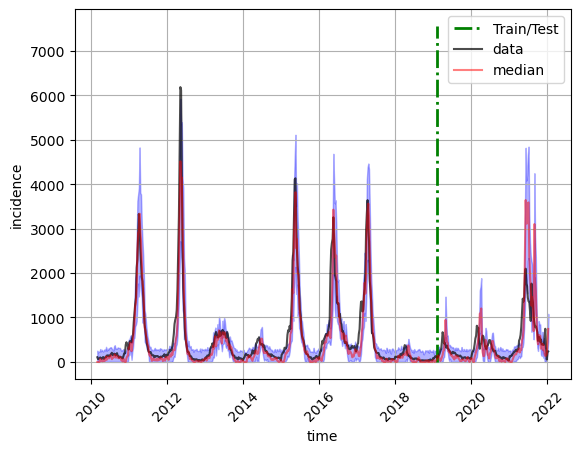

CPU times: user 6min 1s, sys: 20.6 s, total: 6min 22s
Wall time: 5min 34s


In [5]:
%%time

model = build_model(hidden = HIDDEN, features = FEAT, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=1, loss = 'msle')

metrics_msle, hist_msle, m_train, m_val = make_pred(model, CITY, doenca = 'dengue', epochs = EPOCHS, end_train_date = None, 
                    ratio= 0.75, end_date = END_DATE,
                     predict_n = PREDICT_N, look_back =  LOOK_BACK, label = 'msle', filename = FILENAME_DATA)

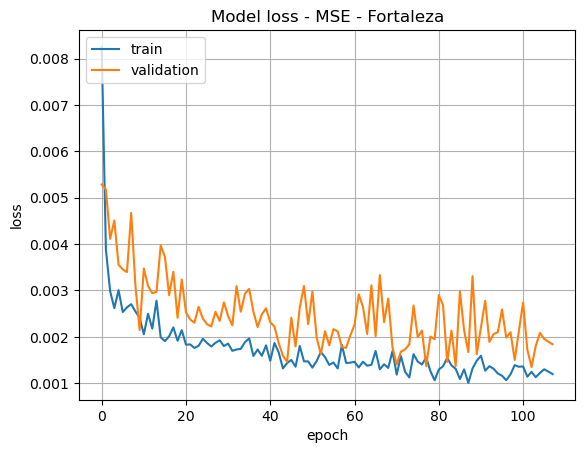

In [6]:
plot_loss(hist_msle, title = 'Model loss - MSE - Fortaleza')

Now, let's retrain the models with all the data available to apply the transfer learning step later:

Compilation Time :  0.002772092819213867
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 52)]           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             3904      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
 

Epoch 33/400
526/526 [==============================] - 2s 4ms/step - loss: 0.0015 - accuracy: 0.3992 - mape: 68.9547 - mse: 0.0026 - val_loss: 0.0023 - val_accuracy: 0.4301 - val_mape: 54.4092 - val_mse: 0.0046
Epoch 34/400
526/526 [==============================] - 2s 4ms/step - loss: 0.0016 - accuracy: 0.3916 - mape: 63.1031 - mse: 0.0029 - val_loss: 0.0025 - val_accuracy: 0.5161 - val_mape: 87.9621 - val_mse: 0.0044
Epoch 35/400
526/526 [==============================] - 2s 5ms/step - loss: 0.0015 - accuracy: 0.3821 - mape: 61.5006 - mse: 0.0027 - val_loss: 0.0030 - val_accuracy: 0.5054 - val_mape: 56.3788 - val_mse: 0.0059
Epoch 36/400
526/526 [==============================] - 3s 5ms/step - loss: 0.0014 - accuracy: 0.4049 - mape: 61.1665 - mse: 0.0025 - val_loss: 0.0020 - val_accuracy: 0.4946 - val_mape: 53.5165 - val_mse: 0.0034
Epoch 37/400
526/526 [==============================] - 2s 5ms/step - loss: 0.0016 - accuracy: 0.4163 - mape: 65.3487 - mse: 0.0028 - val_loss: 0.0029 -

526/526 [==============================] - 2s 4ms/step - loss: 0.0012 - accuracy: 0.3821 - mape: 62.1985 - mse: 0.0021 - val_loss: 0.0041 - val_accuracy: 0.4516 - val_mape: 65.1884 - val_mse: 0.0082
Epoch 72/400
526/526 [==============================] - 2s 5ms/step - loss: 0.0011 - accuracy: 0.4183 - mape: 60.5648 - mse: 0.0019 - val_loss: 0.0029 - val_accuracy: 0.4946 - val_mape: 56.7320 - val_mse: 0.0056
Epoch 73/400
526/526 [==============================] - 2s 4ms/step - loss: 0.0014 - accuracy: 0.4163 - mape: 60.9521 - mse: 0.0026 - val_loss: 0.0025 - val_accuracy: 0.4409 - val_mape: 56.0181 - val_mse: 0.0041
Epoch 74/400
526/526 [==============================] - 2s 4ms/step - loss: 0.0013 - accuracy: 0.3574 - mape: 66.1334 - mse: 0.0024 - val_loss: 0.0027 - val_accuracy: 0.4731 - val_mape: 69.2993 - val_mse: 0.0050
Epoch 75/400
526/526 [==============================] - 2s 4ms/step - loss: 0.0011 - accuracy: 0.4221 - mape: 63.8823 - mse: 0.0019 - val_loss: 0.0029 - val_accuracy

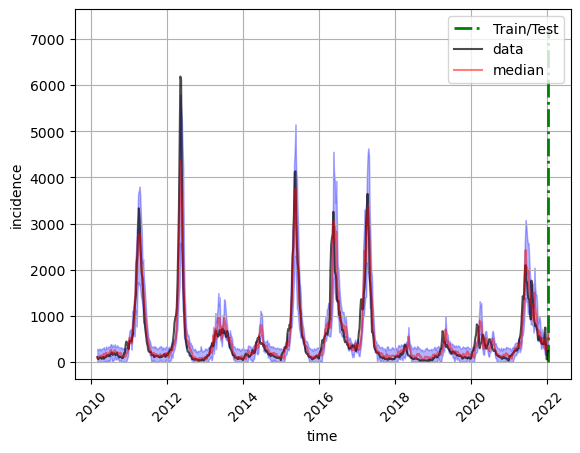

In [7]:
model = build_model(hidden = HIDDEN, features = FEAT, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=1, loss = 'msle')

m_msle_all, h_msle_all, m_train_all, m_val_all = make_pred(model, CITY, doenca = 'dengue', epochs = EPOCHS, end_train_date = None, 
                    ratio= 1.0, end_date = END_DATE,
                     predict_n = PREDICT_N, look_back =  LOOK_BACK, label = 'msle_all',  filename = FILENAME_DATA)

PGBM model

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Estimator 0/100, Train metric: 782.2988
Estimator 1/100, Train metric: 715.3440
Estimator 2/100, Train metric: 654.2045
Estimator 3/100, Train metric: 599.1754
Estimator 4/100, Train metric: 548.5966
Estimator 5/100, Train metric: 503.1710
Estimator 6/100, Train metric: 462.1725
Estimator 7/100, Train metric: 424.5039
Estimator 8/100, Train metric: 390.2086
Estimator 9/100, Train metric: 359.2733
Estimator 10/100, Train metric: 330.9721
Estimator 11/100, Train metric: 305.0231
Estimator 12/100, Train metric: 281.6733
Estimator 13/100, Train metric: 260.2006
Estimator 14/100, Train metric: 239.8554
Estimator 15/100, Train metric: 221.7073
Estimator 16/100, Train metric: 205.2003
Estimator 17/100, Train metric: 190.3482
Estimator 18/100, Train metric: 176.8493
Estimator 19/100, Train metric: 163.7085
Estimator 20/100, Train metric: 152.5929
Estimator 21/100, Train metric: 142.4646
Estimator 22/100, Train metric: 133.3579
Estimator 23/100, Train metric: 125.0447
Estimator 24/100, Train me

Estimator 5/100, Train metric: 508.7566
Estimator 6/100, Train metric: 467.7683
Estimator 7/100, Train metric: 430.7439
Estimator 8/100, Train metric: 397.2984
Estimator 9/100, Train metric: 367.0103
Estimator 10/100, Train metric: 338.9027
Estimator 11/100, Train metric: 313.0851
Estimator 12/100, Train metric: 289.7077
Estimator 13/100, Train metric: 268.8981
Estimator 14/100, Train metric: 250.0684
Estimator 15/100, Train metric: 231.6222
Estimator 16/100, Train metric: 216.0339
Estimator 17/100, Train metric: 200.4401
Estimator 18/100, Train metric: 187.5575
Estimator 19/100, Train metric: 174.3986
Estimator 20/100, Train metric: 163.5707
Estimator 21/100, Train metric: 152.5580
Estimator 22/100, Train metric: 142.8166
Estimator 23/100, Train metric: 133.9513
Estimator 24/100, Train metric: 126.0070
Estimator 25/100, Train metric: 117.5832
Estimator 26/100, Train metric: 110.1061
Estimator 27/100, Train metric: 104.1519
Estimator 28/100, Train metric: 97.8668
Estimator 29/100, Trai

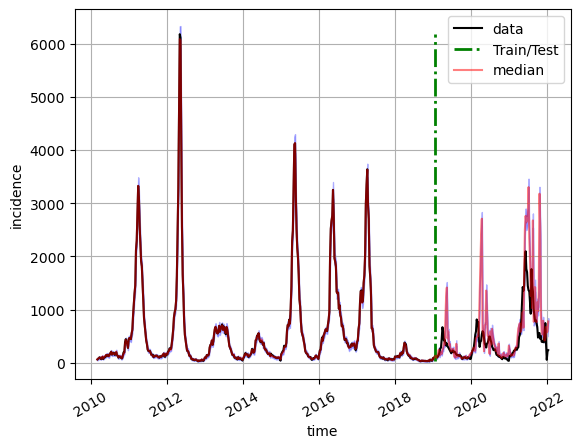

In [8]:

preds, preds25, preds975, X_train, targets = pgbm_pred(CITY, STATE, predict_n = PREDICT_N, look_back = LOOK_BACK,
                                                           doenca = 'dengue', ratio = 0.75, ini_date = None,
                                                           end_date = END_DATE, label = 'train_test',  filename = FILENAME_DATA)

Estimator 0/100, Train metric: 706.5188
Estimator 1/100, Train metric: 646.0963
Estimator 2/100, Train metric: 591.4014
Estimator 3/100, Train metric: 541.8895
Estimator 4/100, Train metric: 496.9026
Estimator 5/100, Train metric: 455.7335
Estimator 6/100, Train metric: 418.7080
Estimator 7/100, Train metric: 385.1536
Estimator 8/100, Train metric: 354.2755
Estimator 9/100, Train metric: 326.5628
Estimator 10/100, Train metric: 301.4694
Estimator 11/100, Train metric: 278.3632
Estimator 12/100, Train metric: 257.4964
Estimator 13/100, Train metric: 238.2737
Estimator 14/100, Train metric: 220.8552
Estimator 15/100, Train metric: 205.1502
Estimator 16/100, Train metric: 190.1677
Estimator 17/100, Train metric: 176.6132
Estimator 18/100, Train metric: 164.2219
Estimator 19/100, Train metric: 153.1644
Estimator 20/100, Train metric: 143.2552
Estimator 21/100, Train metric: 134.1174
Estimator 22/100, Train metric: 125.8127
Estimator 23/100, Train metric: 118.4170
Estimator 24/100, Train me

Estimator 4/100, Train metric: 505.9293
Estimator 5/100, Train metric: 465.7100
Estimator 6/100, Train metric: 429.7053
Estimator 7/100, Train metric: 395.7839
Estimator 8/100, Train metric: 365.5936
Estimator 9/100, Train metric: 337.9813
Estimator 10/100, Train metric: 313.0859
Estimator 11/100, Train metric: 290.0688
Estimator 12/100, Train metric: 268.9432
Estimator 13/100, Train metric: 249.7193
Estimator 14/100, Train metric: 232.6876
Estimator 15/100, Train metric: 217.5845
Estimator 16/100, Train metric: 203.9027
Estimator 17/100, Train metric: 190.2940
Estimator 18/100, Train metric: 177.9705
Estimator 19/100, Train metric: 166.8564
Estimator 20/100, Train metric: 157.3922
Estimator 21/100, Train metric: 148.0881
Estimator 22/100, Train metric: 139.5851
Estimator 23/100, Train metric: 132.4491
Estimator 24/100, Train metric: 126.1129
Estimator 25/100, Train metric: 119.2363
Estimator 26/100, Train metric: 113.3484
Estimator 27/100, Train metric: 108.4957
Estimator 28/100, Trai

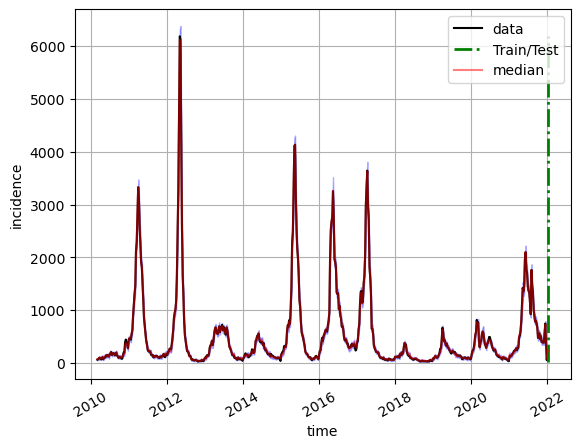

In [9]:
preds, preds25, preds975, X_train, targets = pgbm_pred(CITY, STATE, PREDICT_N, LOOK_BACK, doenca = 'dengue', ini_date = None, end_train_date = END_DATE, end_date = END_DATE,  filename = FILENAME_DATA)
   